In [ ]:
import tensorflow as tf
print(tf.__version__)

import matplotlib.pyplot as plt
import numpy as np
import os
import pathlib
import pandas as pd
%matplotlib inline

2.6.0


In [ ]:
model = tf.keras.models.load_model('advcnn_full.h5')

In [ ]:
classes = ['background','person']

In [ ]:
import pickle
with open('sample_test_images.pickle', 'rb') as file:
    test_generator = pickle.load(file)

In [ ]:
test_images = test_generator[0]
test_labels = test_generator[1]

In [ ]:
test_lab2 = []
for lab in test_labels:
  test_lab2.append(lab[1])
test_lab2[:10]

[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]

In [ ]:
test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

print('\nTest accuracy:', test_acc)

4/4 - 2s - loss: 0.6392 - accuracy: 0.6300

Test accuracy: 0.6299999952316284


In [ ]:
import math
def convert_size(size_bytes):
   if size_bytes == 0:
       return "0B"
   size_name = ("B", "KB", "MB", "GB", "TB", "PB", "EB", "ZB", "YB")
   i = int(math.floor(math.log(size_bytes, 1024)))
   p = math.pow(1024, i)
   s = round(size_bytes / p, 2)
   return "%s %s" % (s, size_name[i])

In [ ]:
print("size of the full model is {} bytes".format(convert_size(os.path.getsize('advcnn_full.h5'))))

size of the full model is 315.71 MB bytes


In [ ]:
predictions = model.predict(test_images)
predictions[:10]

array([[0.4891616 , 0.51248336],
       [0.5248845 , 0.48083615],
       [0.4233984 , 0.56620836],
       [0.5523657 , 0.4582519 ],
       [0.82080024, 0.1767641 ],
       [0.27782094, 0.6949229 ],
       [0.3983218 , 0.60410756],
       [0.22848964, 0.7768253 ],
       [0.46440366, 0.5308909 ],
       [0.81892705, 0.17865446]], dtype=float32)

In [ ]:
full_model_pred = []
full_model_pred_values = []
for pred in predictions:
  full_model_pred_values.append(pred[1])
  if pred[1] > 0.5: full_model_pred.append(1)
  else: full_model_pred.append(0)
full_model_pred[:10]

[1, 0, 1, 0, 0, 1, 1, 1, 1, 0]

In [ ]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred, full_model_pred_values)),
                          columns=['actual', 'full', 'full_vals'])
df_results.head()

,actual,full,full_vals
0,1.0,1,0.512483
1,0.0,0,0.480836
2,1.0,1,0.566208
3,0.0,0,0.458252
4,0.0,0,0.176764


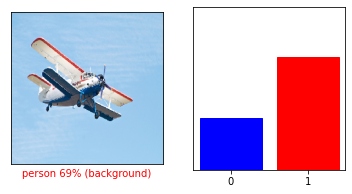

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[i], cmap=plt.cm.binary)
    if predictions_array[0] > predictions_array[1]:
        pred = 0
    else: pred = 1
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    if pred == act:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(classes[pred],
                                100*np.max(predictions_array),
                                classes[act]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    if predictions_array[0] > predictions_array[1]:
        pred = 0
    else: pred = 1
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    thisplot[pred].set_color('red')
    thisplot[act].set_color('blue')

i = 22
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

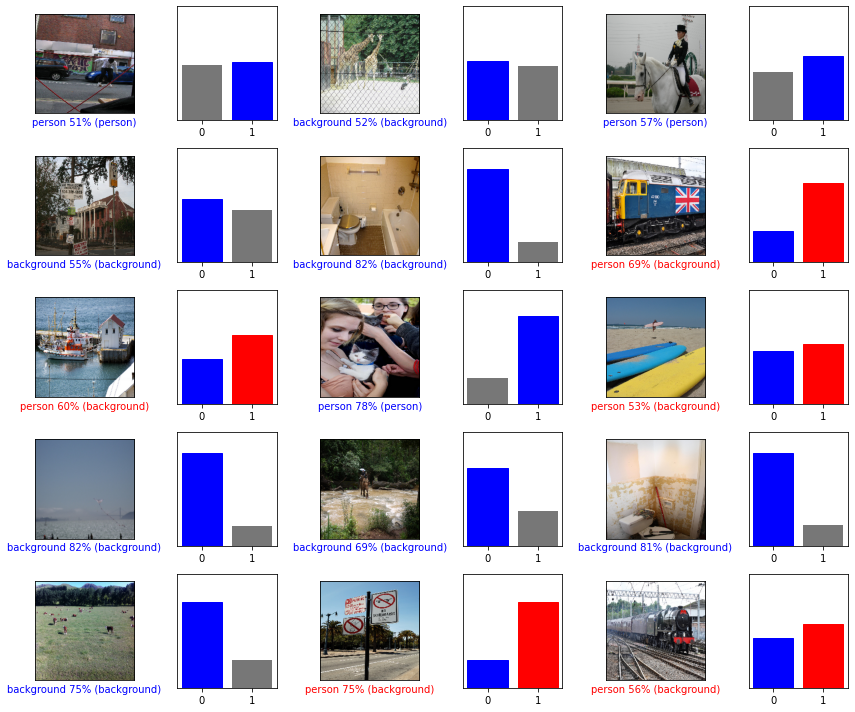

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

(250, 250, 3)
(1, 250, 250, 3)
[[0.5248845  0.48083618]]


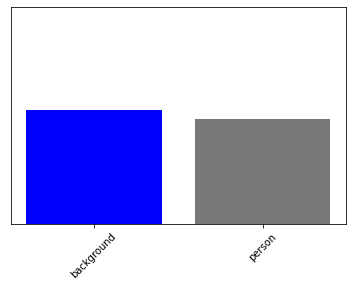

In [ ]:
img = test_images[1]
print(img.shape)
img = (np.expand_dims(img,0))
print(img.shape)
predictions_single = model.predict(img)
print(predictions_single)

plot_value_array(1, predictions_single[0], test_labels)
_ = plt.xticks(range(2), classes, rotation=45)
plt.show()

Model Convertion to TensorFlow Lite model

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)

tflite_model = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmphxrayl2l/assets


INFO:tensorflow:Assets written to: /tmp/tmphxrayl2l/assets


In [ ]:
open("tflite_model.tflite", "wb").write(tflite_model)

110335764

In [ ]:
size = os.path.getsize('tflite_model.tflite')

In [ ]:
convert_size(size)

'105.22 MB'

Save file for models as files

In [ ]:
tflite_models_dir = pathlib.Path("tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

In [ ]:
# Save the unquantized/float TF Lite model:
tflite_model_file = tflite_models_dir/"tflite_model.tflite"
tflite_model_file.write_bytes(tflite_model)

110335764

reduced 1 third of the size but still large as TensorFlow lite model still using 32-bit float values and all the parameters. 

In [ ]:
# Helper function to evaluate a TFLite model on all images
def evaluate_model(tflite_file, model_type):
  global test_images
  global test_lab2

  test_image_indices = range(test_images.shape[0])
  predictions = run_tflite_model(tflite_file, test_image_indices)

  accuracy = (np.sum(test_lab2== predictions) * 100) / len(test_images)

  print('%s model accuracy is %.4f%% (Number of test samples=%d)' % (
      model_type, accuracy, len(test_images)))

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(30):
    # Model has only one input so each data point has one element.
    yield [input_value]

def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(test_images).batch(1).take(30):
    yield [input_value]

In [ ]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions[i] = output.argmax()

  return predictions


In [ ]:
# Change this to test a different image
test_image_index = 1

## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):
  global test_labels

  predictions = run_tflite_model(tflite_file, [test_image_index])

  plt.imshow(test_images[test_image_index])
  template = model_type + " Model \n True:{true}, Predicted:{predict}"
  _ = plt.title(template.format(true= str(test_labels[test_image_index]), predict=str(predictions[0])))
  plt.grid(False)

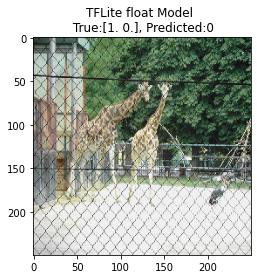

In [ ]:
test_model(tflite_model_file, test_image_index, model_type="TFLite float")

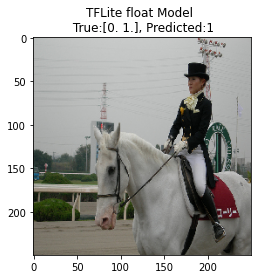

In [ ]:
test_model(tflite_model_file, test_image_index=2, model_type="TFLite float")

In [ ]:
evaluate_model(tflite_model_file, model_type="TFLite float")

TFLite float model accuracy is 63.0000% (Number of test samples=100)


In [ ]:
test_image_indices = range(test_images.shape[0])
pred_TFLite = run_tflite_model(tflite_model_file, test_image_indices)
pred_TFLite[:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite )),
                          columns=['actual', 'full', 'full_vals','tflite'])
df_results.head()

,actual,full,full_vals,tflite
0,1.0,1,0.512483,1
1,0.0,0,0.480836,0
2,1.0,1,0.566208,1
3,0.0,0,0.458252,0
4,0.0,0,0.176764,0


now enabled the default optimizations flag to quantize all fixed parramters such as weights

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp00ulkr29/assets


INFO:tensorflow:Assets written to: /tmp/tmp00ulkr29/assets


In [ ]:
open("tflite_model_quant.tflite", "wb").write(tflite_model_quant)

27592240

In [ ]:
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('tflite_model_quant.tflite'))))

size after quanized. is 26.31 MB bytes


This is a significant reduction. but weigts are still in float format

In [ ]:
tflite_model_quant_file = tflite_models_dir/"tflite_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

27592240

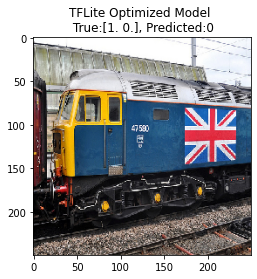

In [ ]:
test_model(tflite_model_quant_file, test_image_index=5, model_type="TFLite Optimized")

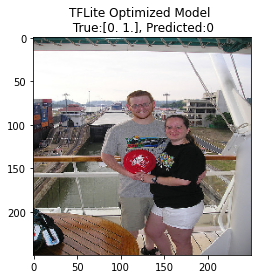

In [ ]:
test_model(tflite_model_quant_file, test_image_index=16, model_type="TFLite Optimized")

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="TFLite float")

TFLite float model accuracy is 64.0000% (Number of test samples=100)


In [ ]:
test_image_indices = range(test_images.shape[0])
pred_TFLite_opt = run_tflite_model(tflite_model_quant_file, test_image_indices)
pred_TFLite_opt[:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite,
                                   pred_TFLite_opt)),
                          columns=['actual', 'full', 'full_vals','tflite','tflite_opt'])
df_results.head()

,actual,full,full_vals,tflite,tflite_opt
0,1.0,1,0.512483,1,0
1,0.0,0,0.480836,0,0
2,1.0,1,0.566208,1,0
3,0.0,0,0.458252,0,0
4,0.0,0,0.176764,0,0


converting using float fall back quantization

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen

tflite_model_quant_rep = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp9yujwwpr/assets


INFO:tensorflow:Assets written to: /tmp/tmp9yujwwpr/assets


In [ ]:
open("tflite_model_quant_rep.tflite", "wb").write(tflite_model_quant_rep)

27592256

In [ ]:
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('tflite_model_quant_rep.tflite'))))

size after quanized. is 26.31 MB bytes


In [ ]:
tflite_model_quant_rep_file = tflite_models_dir/"tflite_model_quant_rep.tflite"
tflite_model_quant_rep_file.write_bytes(tflite_model_quant_rep)

27592256

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant_rep)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.float32'>
output:  <class 'numpy.float32'>


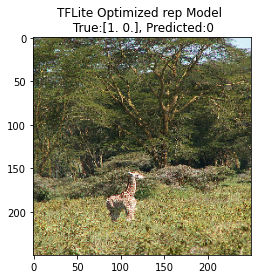

In [ ]:
test_model(tflite_model_quant_rep_file, test_image_index=30, model_type="TFLite Optimized rep")

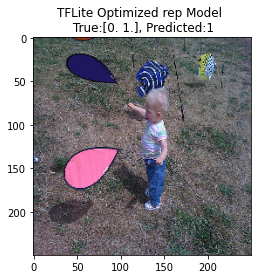

In [ ]:
test_model(tflite_model_quant_rep_file, test_image_index=31, model_type="TFLite Optimized rep")

In [ ]:
evaluate_model(tflite_model_quant_rep_file, model_type="TFLite optim rep")

TFLite optim rep model accuracy is 63.0000% (Number of test samples=100)


In [ ]:
pred_TFLite_opt_rep = run_tflite_model(tflite_model_quant_rep_file, test_image_indices)
pred_TFLite_opt_rep[:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite,
                                   pred_TFLite_opt, pred_TFLite_opt_rep)),
                          columns=['actual', 'full', 'full_vals','tflite','tflite_opt',
                                   'tflite_opt_rep'])
df_results.head()

,actual,full,full_vals,tflite,tflite_opt,tflite_opt_rep
0,1.0,1,0.512483,1,0,1
1,0.0,0,0.480836,0,0,0
2,1.0,1,0.566208,1,0,1
3,0.0,0,0.458252,0,0,0
4,0.0,0,0.176764,0,0,0


to maintain compatibility with applications that traditionally use float model input and output tensors, the TensorFlow Lite Converter leaves the model input and output tensors in float:

but it won't be compatible with devices that perform only integer-based operations, such as the Edge TPU.

In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_int8 = converter.convert()

INFO:tensorflow:Assets written to: /tmp/tmp04y3dpx2/assets


INFO:tensorflow:Assets written to: /tmp/tmp04y3dpx2/assets


In [ ]:
open("tflite_int8.tflite", "wb").write(tflite_int8)
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('tflite_int8.tflite'))))

size after quanized. is 26.31 MB bytes


In [ ]:
tflite_int8_file = tflite_models_dir/"tflite_int8.tflite"
tflite_int8_file.write_bytes(tflite_int8)

27592328

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_int8)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


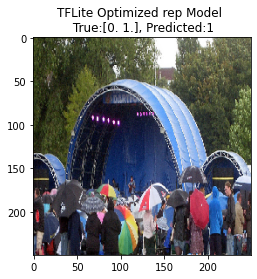

In [ ]:
test_model(tflite_int8_file, test_image_index=35, model_type="TFLite Optimized rep")

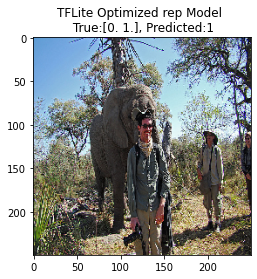

In [ ]:
test_model(tflite_int8_file, test_image_index=36, model_type="TFLite Optimized rep")

In [ ]:
evaluate_model(tflite_int8_file, model_type="TFLite int")

TFLite int model accuracy is 63.0000% (Number of test samples=100)


In [ ]:
pred_TFLite_int = run_tflite_model(tflite_int8_file, test_image_indices)
pred_TFLite_int[:10]

array([1, 0, 1, 0, 0, 1, 1, 1, 1, 0])

In [ ]:
df_results = pd.DataFrame(list(zip(test_lab2, full_model_pred,full_model_pred_values, pred_TFLite,
                                   pred_TFLite_opt, pred_TFLite_opt_rep, pred_TFLite_int)),
                          columns=['actual', 'full', 'full_vals','tflite','tflite_opt',
                                   'tflite_opt_rep', 'tflite_int'])
df_results.head()

,actual,full,full_vals,tflite,tflite_opt,tflite_opt_rep,tflite_int
0,1.0,1,0.512483,1,0,1,1
1,0.0,0,0.480836,0,0,0,0
2,1.0,1,0.566208,1,0,1,1
3,0.0,0,0.458252,0,0,0,0
4,0.0,0,0.176764,0,0,0,0


In [ ]:
df_results.to_csv('results_100.csv')

In [ ]:
df_results

,actual,full,full_vals,tflite,tflite_opt,tflite_opt_rep,tflite_int
0,1.0,1,0.512483,1,0,1,1
1,0.0,0,0.480836,0,0,0,0
2,1.0,1,0.566208,1,0,1,1
3,0.0,0,0.458252,0,0,0,0
4,0.0,0,0.176764,0,0,0,0
...,...,...,...,...,...,...,...
95,0.0,0,0.320987,0,0,0,0
96,0.0,0,0.404137,0,0,0,0
97,1.0,1,0.581777,1,0,1,1
98,1.0,1,0.761728,1,0,1,1


In [ ]:
dfdf 

NameError: ignored

In [ ]:
open("v1_con3.tflite", "wb").write(tflite_model_quant)
print("size after quanized. is {} bytes".format(convert_size(os.path.getsize('v1_con3.tflite'))))

In [ ]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

save lite model as files

In [ ]:
# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"model.tflite"
tflite_model_file.write_bytes(tflite_model)

In [ ]:
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

Running TensorFlow Lite Models

In [ ]:
test_model(tflite_model_file, test_image_index, model_type="Float")

In [ ]:
test_model(tflite_model_quant_file, test_image_index, model_type="Quantized")

In [ ]:
evaluate_model(tflite_model_file, model_type="Float")

In [ ]:
evaluate_model(tflite_model_quant_file, model_type="Quantized")

In [ ]:
test_image_index = 1
test_image_indices = range(test_images.shape[0])
predictions = run_tflite_model(tflite_model_quant_file, test_image_indices)
predictions

In [ ]:
tflite_file = tflite_model_quant_file
# Initialize the interpreter
interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
interpreter.allocate_tensors()

In [ ]:
interpreter

In [ ]:
input_details = interpreter.get_input_details()[0]
output_details = interpreter.get_output_details()[0]

In [ ]:
input_details

In [ ]:
output_details

In [ ]:
test_image_indices = range(test_images.shape[0])
test_image_indices

In [ ]:
np.zeros((len(test_image_indices),), dtype=int)

In [ ]:
for i, test_image_index in enumerate(test_image_indices):
    test_image = test_images[test_image_index]
    test_label = test_labels[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()

    output = interpreter.get_tensor(output_details["index"])[0]
    print(output.argmax())



In [ ]:
test_image.shape, test_label.shape, input_scale, input_zero_point

In [ ]:
print(test_label[1])
print(test_labels[2])

In [ ]:
def plot_image(i, predictions_array, true_label, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img[i], cmap=plt.cm.binary)
    # if predictions_array[0] > predictions_array[1]:
        # pred = 0
    # else: pred = 1
    pred = predictions_array
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    if pred == act:
        color = 'blue'
    else:
        color = 'red'
        
    plt.xlabel("{} {:2.0f}% ({})".format(classes[pred],
                                100*np.max(predictions_array),
                                classes[act]),
                                color=color)
    
def plot_value_array(i, predictions_array, true_label):
    plt.grid(False)
    plt.xticks(range(2))
    plt.yticks([])
    thisplot = plt.bar(range(2), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)
    
    # if predictions_array[0] > predictions_array[1]:
    #     pred = 0
    # else: pred = 1
    pred = predictions_array
    if true_label[i][0] > true_label[i][1]:
        act = 0
    else: act =1 

    thisplot[pred].set_color('red')
    thisplot[act].set_color('blue')

i = 4
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

In [ ]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

Statistical significance

In [ ]:
!pip install mlxtend -q
import mlxtend

In [ ]:
# load data
X, y = test_images, test_lab2
# define models
model1 = tflite_model_file
model2 = tflite_model_quant_file

In [ ]:
# compare algorithms
t, p = mlxtend.paired_ttest_5x2cv(estimator1=model1, estimator2=model2, X=X, y=y)

In [ ]:
# interpret the result
if p <= 0.05:
	print('Difference between mean performance is probably real')
else:
	print('Algorithms probably have the same performance')


In [ ]:
from numpy import mean
from numpy import std
